In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

# Demo of the trained Colorization Model

For now just colorizes the images of a video, and stores them as a new video.

In [2]:
from DataLoad import CustomImageDataset, data_to_images
from format_transforms import *

## 1. Data Loading

using the pytorch dataloader and dataset implementation from DataLoad.py

In [3]:
use_flow=True

dataset = CustomImageDataset(resolution='176p', use_flow=use_flow)

dataset_size = len(dataset)
print('Dataset size:', dataset_size)

vid labels: ['bear', 'bike-packing', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'boxing-fisheye', 'breakdance', 'breakdance-flare', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'cat-girl', 'classic-car', 'color-run', 'cows', 'crossing', 'dance-jump', 'dance-twirl', 'dancing', 'disc-jockey', 'dog', 'dog-agility', 'dog-gooses', 'dogs-jump', 'dogs-scale', 'drift-chicane', 'drift-straight', 'drift-turn', 'drone', 'elephant', 'flamingo', 'goat', 'gold-fish', 'hike', 'hockey', 'horsejump-high', 'horsejump-low', 'india', 'judo', 'kid-football', 'kite-surf', 'kite-walk', 'koala', 'lab-coat', 'lady-running', 'libby', 'lindy-hop', 'loading', 'longboard', 'lucia', 'mallard-fly', 'mallard-water', 'mbike-trick', 'miami-surf', 'motocross-bumps', 'motocross-jump', 'motorbike', 'night-race', 'paragliding', 'paragliding-launch', 'parkour', 'pigs', 'planes-water', 'rallye', 'rhino', 'rollerblade', 'schoolgirls', 'scooter-black', 'scooter-board', 'scooter-gray', 'sheep', 'shooting', 's

## 2. Model Loading

In [4]:
from Model_UNet import UNet
from DataLoad import CustomImageDataset, data_to_images, images_to_data

print("Cuda available: ", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device)

Cuda available:  True
Using device:  cuda


In [5]:
# initialize model
if use_flow:
    n_input_channels = 6
else:
    n_input_channels = 4

model = UNet(n_input_channels=n_input_channels)
model.to(device)

# Hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 300

# Initialize the loss function
loss_fn = nn.MSELoss()


# Data loader
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
model_path = '~/Documents/Colorization/Models/'
UNet_folder = 'UNet'
model_path = os.path.expanduser(model_path)
UNet_folder = os.path.join(model_path, UNet_folder)

def checkpoint(model, filename):
    filename = os.path.join(UNet_folder, filename)
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    filename = os.path.join(UNet_folder, filename)
    model.load_state_dict(torch.load(filename))

In [7]:
model_folder = 'UNet_farneback_'+str(150)+'_epochs'

filename = 'UNet_farneback_epoch_149.pth'

resume(model, os.path.join(model_folder, filename))

## 3. Image view

In [14]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def save_image(image, image_path):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(image_path, image)

In [15]:
dataset_path = '~/Documents/Colorization/Datasets/'
dataset_name = 'DAVIS'
image_folder = 'JPEGImages'

train_folder = 'train'
test_folder = 'test_dev'

dataset_path = os.path.expanduser(dataset_path)
dataset_path = os.path.join(dataset_path, dataset_name)
img_folder_path = os.path.join(dataset_path, test_folder, image_folder)
nd_array_path = os.path.join(dataset_path, test_folder, 'nd_arrays')
nd_array_path = os.path.join(nd_array_path, '176p_farneback')

resolution = '176p'
label = 'gray'
img_folder_path = os.path.join(img_folder_path, resolution+'_'+label)

Video name: chamaleon


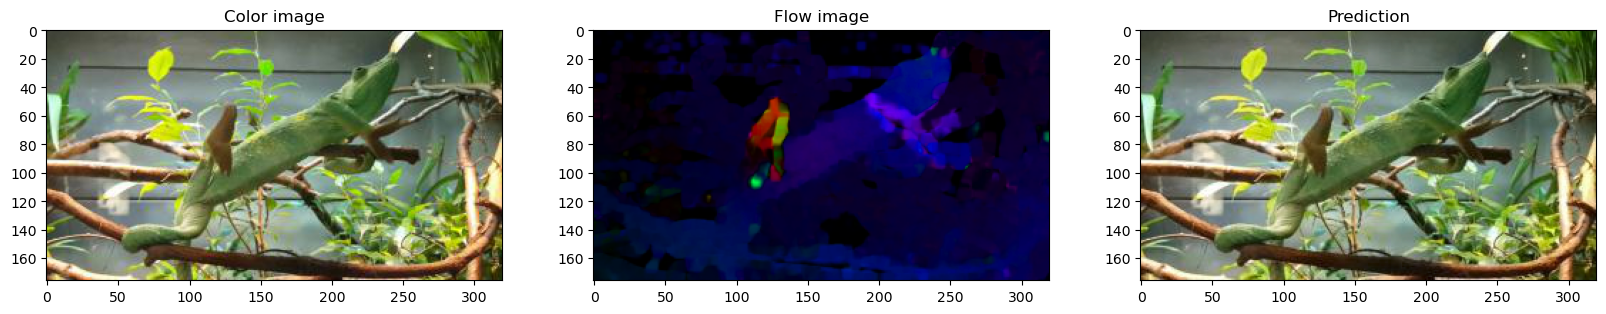

Video name: mtb-race


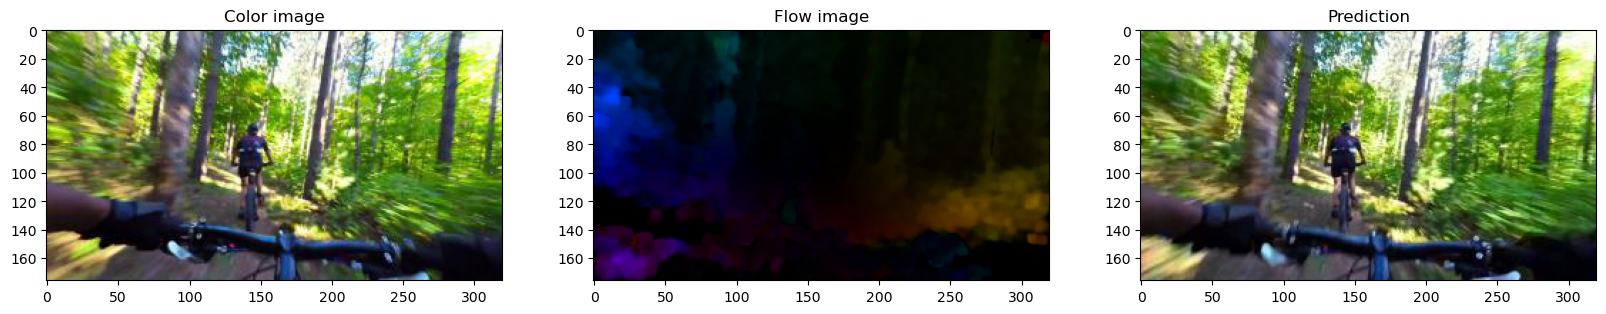

Video name: horsejump-stick


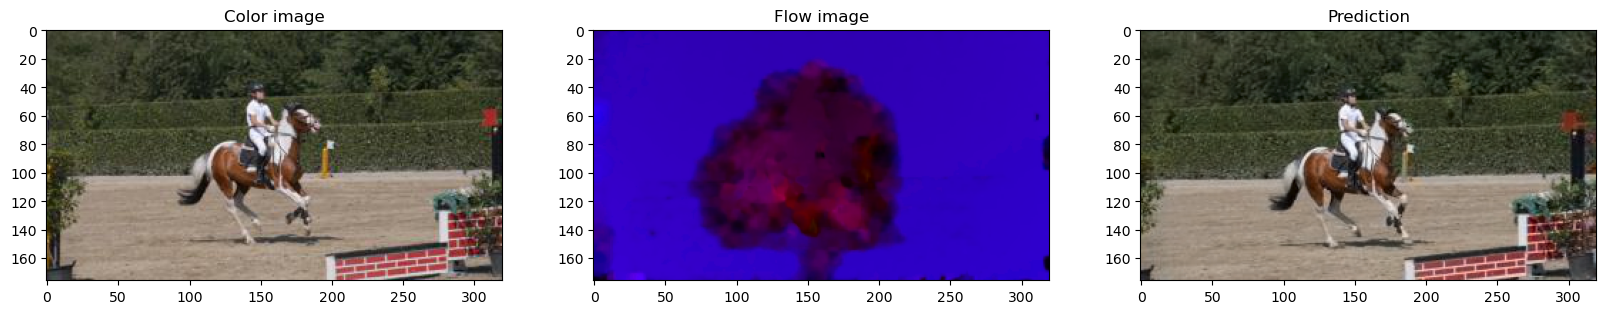

Video name: salsa


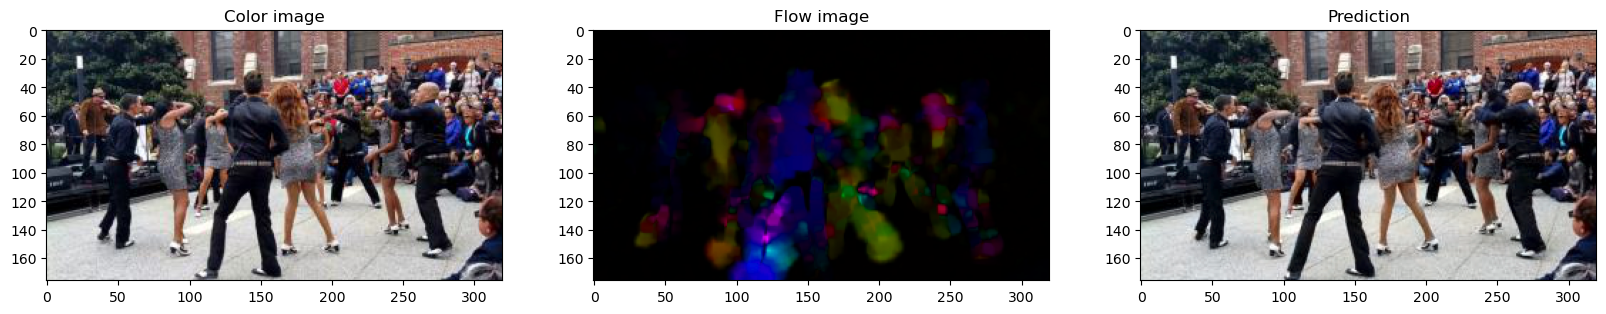

Video name: circus


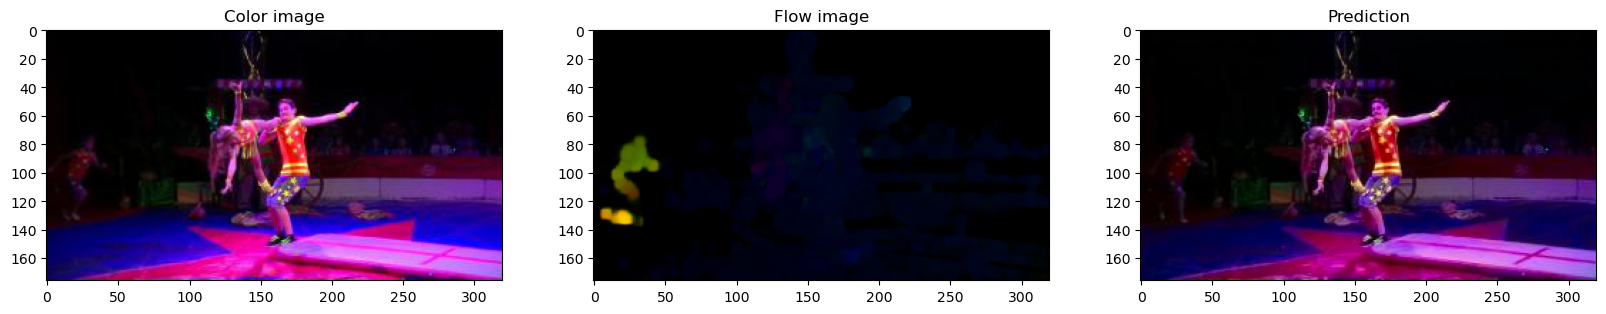

Video name: mascot


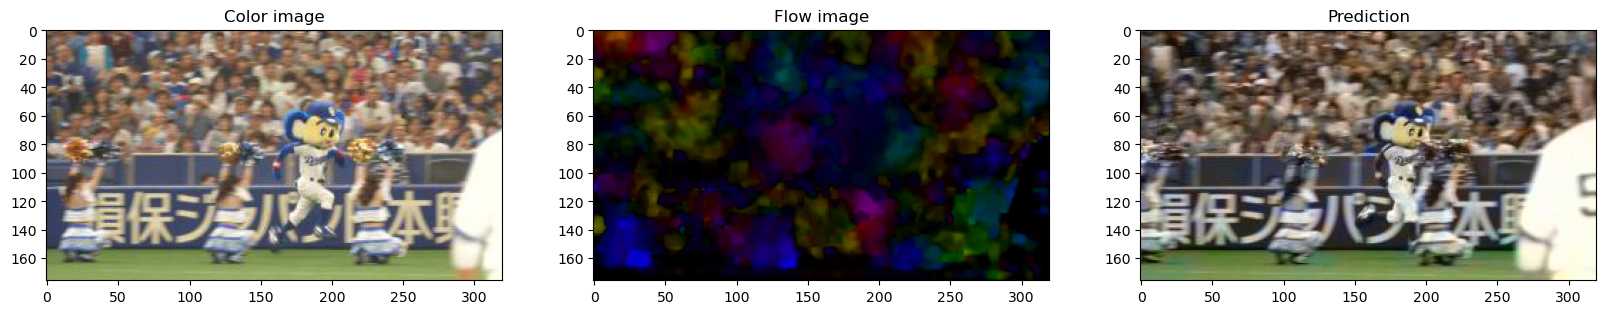

Video name: aerobatics


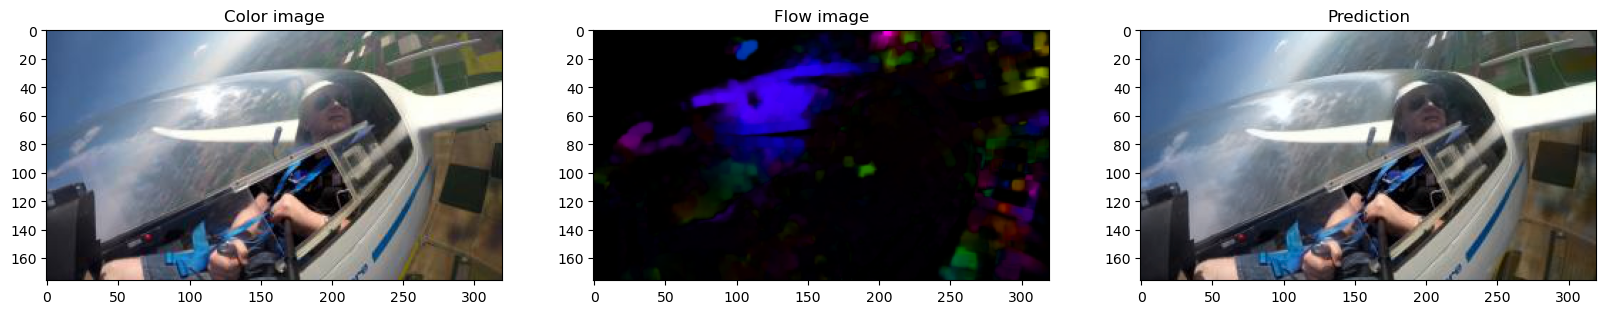

Video name: helicopter-landing


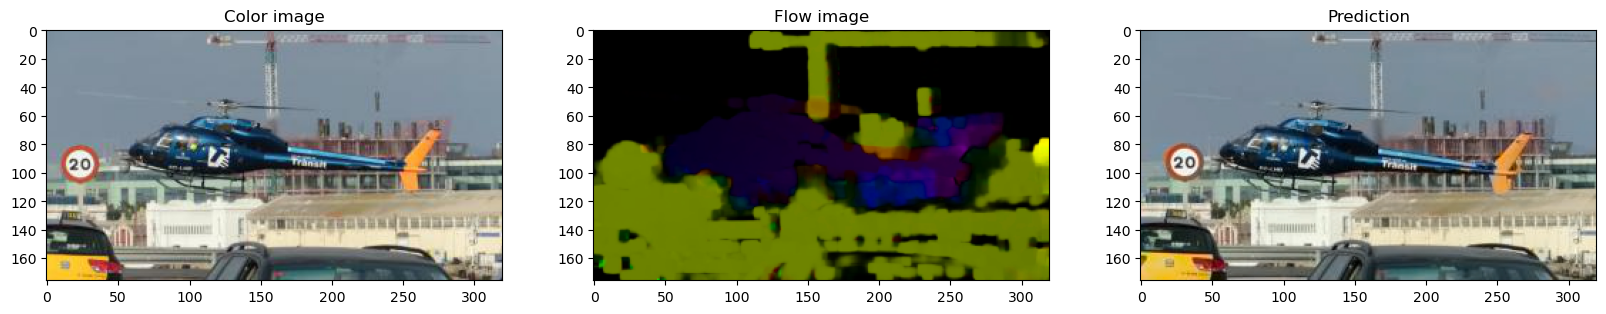

Video name: hoverboard


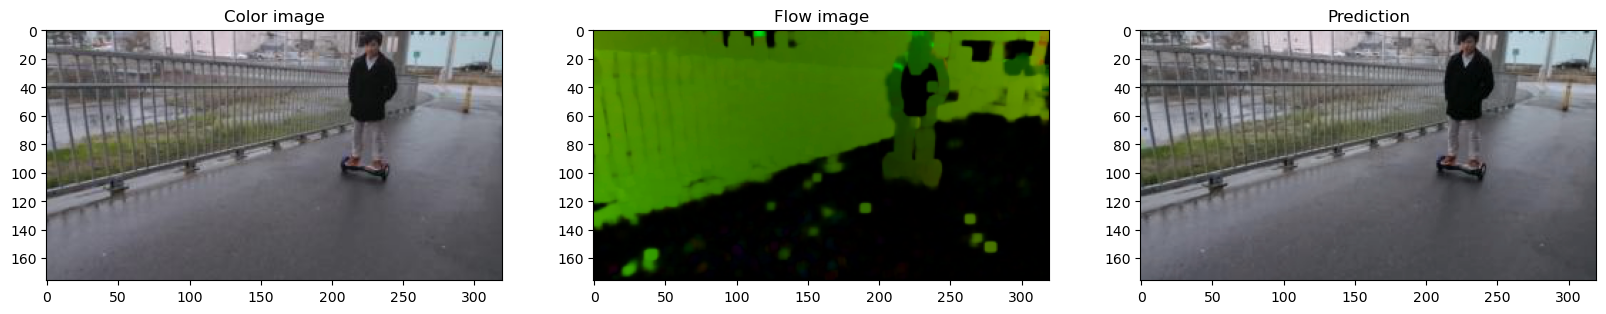

Video name: skate-jump


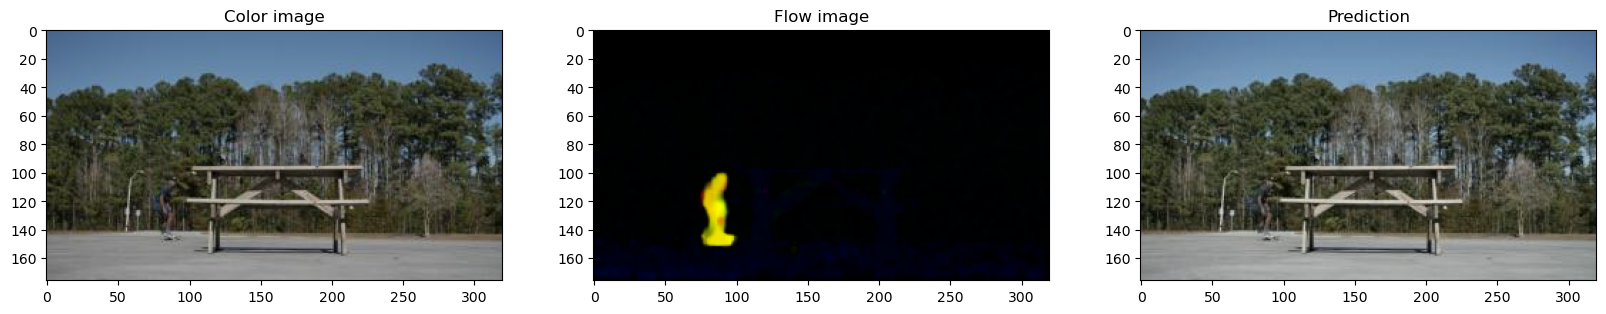

In [16]:
for video_name in os.listdir(img_folder_path)[0:10]:
    print('Video name:', video_name)
    video_path = os.path.join(img_folder_path, video_name)

    col_img = load_image(os.path.join(dataset_path, test_folder, image_folder,resolution,video_name, '00000.jpg'))

    gray_img = None
    flow_img = None
    i = 1
    
    img_path = os.path.join(video_path, str(i).zfill(5)+'.jpg')
    gray_img = load_image(img_path)
    if use_flow:
        flow_frame = flow_frame = os.path.join(nd_array_path,video_name, str(i).zfill(5) + '.jpg.npy')
        flow_img = np.load(flow_frame)
    
    input, _ = images_to_data(col_img, flow_img, gray_img)
    
    prediction = model(input.unsqueeze(0).to(device))
    prediction = prediction.cpu()
    prediction = prediction.detach()
    prediction = prediction.squeeze(0)

    _, flow_img, grey_img, pred_img = data_to_images(input, prediction, use_flow=use_flow, input_only=False)


    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(col_img)
    plt.title('Color image')
    plt.subplot(1,3,2)
    plt.imshow(uv_2_rgb(flow_img))
    plt.title('Flow image')
    plt.subplot(1,3,3)
    plt.imshow(pred_img)
    plt.title('Prediction')
    plt.show()


## 3. Video Rendering

In [17]:
save_label = 'UNet_farneback'

In [18]:
for video_name in os.listdir(img_folder_path):
    print('Video name:', video_name)
    video_path = os.path.join(img_folder_path, video_name)
    save_path = '~/Documents/Colorization/Results/'
    save_path = os.path.expanduser(save_path)
    save_path = os.path.join(save_path, save_label, video_name)
    make_dir(save_path)
    still_path = os.path.join(save_path, 'stills')
    make_dir(still_path)

    n_frames = len(os.listdir(video_path))
    print('Number of frames:', n_frames)

    col_img = load_image(os.path.join(dataset_path, test_folder, image_folder,resolution,video_name, '00000.jpg'))

    gray_img = None
    flow_img = None
    i = 1
    while i < n_frames:
        img_path = os.path.join(video_path, str(i).zfill(5)+'.jpg')
        gray_img = load_image(img_path)
        if use_flow:
            flow_frame = flow_frame = os.path.join(nd_array_path,video_name, str(i).zfill(5) + '.jpg.npy')
            flow_img = np.load(flow_frame)
        
        input, _ = images_to_data(col_img, flow_img, gray_img)
        
        prediction = model(input.unsqueeze(0).to(device))
        prediction = prediction.cpu()
        prediction = prediction.detach()
        prediction = prediction.squeeze(0)

        _, flow_img, grey_img, pred_img = data_to_images(input, prediction, use_flow=use_flow, input_only=False)

        save_image(pred_img, os.path.join(still_path, str(i).zfill(5)+'.jpg'))

        

        col_img = pred_img
        i+=1

    images_2_video(still_path, os.path.join(save_path, video_name+'.avi'), fps=10)

Video name: chamaleon
Number of frames: 85
Video name: mtb-race
Number of frames: 69
Video name: horsejump-stick
Number of frames: 58
Video name: salsa
Number of frames: 86
Video name: circus
Number of frames: 73
Video name: mascot
Number of frames: 78
Video name: aerobatics
Number of frames: 71
Video name: helicopter-landing
Number of frames: 77
Video name: hoverboard
Number of frames: 81
Video name: skate-jump
Number of frames: 68
Video name: ducks
Number of frames: 75
Video name: kids-robot
Number of frames: 75
Video name: tennis-vest
Number of frames: 75
Video name: car-competition
Number of frames: 66
Video name: giant-slalom
Number of frames: 127
Video name: jet-ski
Number of frames: 83
Video name: cat
Number of frames: 52
Video name: robot-battle
Number of frames: 85
Video name: ice-hockey
Number of frames: 52
Video name: deer
Number of frames: 79
Video name: hurdles-race
Number of frames: 55
Video name: snowboard-race
Number of frames: 75
Video name: subway
Number of frames: 88

In [36]:
import colorizers

colorizer_eccv16 = colorizers.eccv16().eval()
colorizer_siggraph17 = colorizers.siggraph17().eval()